# Carlini Wagner Attacks

In [7]:
import xlab
xlab.hello_world()

# get CIFAR10 helper functions 
from xlab.utils import CIFAR10
itos, stoi = CIFAR10.itos, CIFAR10.stoi

# for loading our model
from robustbench.utils import load_model

# pytorch imports
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# for plotting
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"You are using device: {device}")

Hello world! You are using version 0.1.7 of the package
You are using device: cuda


In [8]:
# load our data
NUM_EXAMPLES = 100
x_test, y_test = xlab.utils.load_cifar10_test_samples(n=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

Files already downloaded and verified
x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


We will begin by loading a pretrained model for classification on CIFAR using robustbench. This is a much larger more impressive model than the one you looked at in the previous section.

In [9]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to(device)
_ = model.eval()

First let's take a look at what we have. We can see that there is about 36.5 million trainable pameters in the model. This is actually quite large! For reference, we will be looking at the smallest version of GPT-2 later in the course. That has 128 million parameters, meaning our classifer is only a third of the size of the smallest transformer-based language models.

In [10]:
# print the parameter count
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


## Tasks 1-5: Writing the function $f(x + \delta)$

Recall that we will be using a loss to minimize the equation below.
$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$

The function $\mathcal{D}$ measures how different $x$ (the original image) is from $x + \delta$ where $\delta$ is the purtubations we are making to the image. In the original paper, Carlini and Wagner list seven of reasonable choices you could make for $f$. For brevity, you will only implement and compare 3 of them. 

Note that the equations below are presented slightly differently than in the original paper. They are all mathematically equivalent, but we have rewritten some for clarity. 

<details>
<summary>⚠️ <b>Caution</b></summary>

In this section we will have you implement 3 out of the 7 choices for $f$. We encourage you to implement the other choices of $f$ from [the paper](https://arxiv.org/pdf/1608.04644) if you are interested. We will caution you however that there appears to be a sign error in equation #1. The correct equation with the right signs should be shown below. Cross Entropy here will be taken with $\log_2$ rather than $\log_e$.

$$
f_1(x_{\mathrm{adversarial}}) = \mathrm{CrossEntropy}(F(x_{\mathrm{adversarial}})) - 1
$$

In general we find that the "Objective Function" section of the paper has several mistakes . For example they say that they "define an objective function $f$ such that $C(x + \delta) = t$ if and only if $f(x + \delta) \leq 0$." but it is trivial to show that equation 4 does not satisfy the "if and only if" condition.

</details>

### Task #1: Implementing $f_2$

For task #1 you will implement $f_2$ from [the paper](https://arxiv.org/pdf/1608.04644). 

The equation for $f_2$ is below. $F_t(x)$ is the model output for class $t$ including the [softmax](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) which gives probabilities rather than logits. The first term in this equation takes the greatest softmax probability that is not the target class. We encourage you to pause and think about why the equation is structured in the way that it is.

$$
f_2(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(F(x_{\mathrm{adversarial}})) - F_t(x_{\mathrm{adversarial}}))
$$

In [11]:
def f2(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(softmax_probs)
    if i_neq_t == target:
        masked_probs = softmax_probs.clone()
        masked_probs[target] = float('-inf')
        i_neq_t = torch.argmax(masked_probs)
    return F.relu(softmax_probs[i_neq_t] - softmax_probs[target])

In [65]:
x = torch.tensor([1.0, 3.0])
print(f2(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f2(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f2(x, 0)) # should be =0

tensor(0.7616)
tensor(0.)
tensor(0.)


### Task #2: Implementing $f_4$

This is similar to the equation above. The only difference is that we are inforcing the requirement that the target class has a probability greater than or equal to 0.5 rather a probability greater than or equal to any of the other classes.

$$
f_4(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(0.5 - F_t(x_{\mathrm{adversarial}}))
$$

In [66]:
def f4(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    return F.relu(0.5 - softmax_probs[target])

In [67]:
x = torch.tensor([1.0, 3.0])
print(f4(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f4(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f4(x, 0)) # should be =0

tensor(0.3808)
tensor(0.)
tensor(0.)


### Task #3: Implementing $f_6$

This is very similar ot $f_2$. The difference is we use $Z_t(x)$ instead of $F_t(x)$. $Z_t(x)$ is the raw output of the model for class $t$ rather than the output after the softmax.

$$
f_6(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(Z(x_{\mathrm{adversarial}})) - Z_t(x_{\mathrm{adversarial}}))
$$

In [68]:
def f6(logits, target):
    # softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        masked_logits = logits.clone()
        masked_logits[target] = float('-inf')
        i_neq_t = torch.argmax(masked_logits)
    return F.relu(logits[i_neq_t] - logits[target])

In [69]:
x = torch.tensor([1.0, 3.0])
print(f6(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f6(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f6(x, 0)) # should be =0

tensor(2.)
tensor(0.)
tensor(0.)


By now you should have several options for $f$. Now we can optimize the below equation below where we let $\mathcal{D}(x, x + \delta)$ be the $L_2$ norm.

$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$


We have implemented this below for you. The attack is extremely similar to the PGD attack you coded in the previous notebook so it should look familiar to you. Still, you should read through the code and make sure you understand everything!

In [70]:
def cw_loss_v1(f, x, y, delta, c, model):
    logits = model(x + delta)
    f_loss = f(logits[0], y)
    norm_loss = (torch.sum(delta**2))**1/2

    return norm_loss + c * f_loss

def cw_simple(f, x, y, c, model, num_iters):
    delta = torch.randn_like(x) * 0.1
    delta.requires_grad = True
    optimizer = optim.Adam([delta], lr=1e-2)

    for i in range(num_iters):
        l = cw_loss_v1(f, x, y, delta, c, model)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 5 == 0:
            print(f"iteration {i + 1}:\t loss={l.item():.4f}")
    return torch.clip(x + delta, 0, 1)

### Task #4: Test different $f$ functions

The next step is to fill in the missing code below to test how effective different choices of $f$ are. When running `benchmark_f` for `f2`, `f4` and `f6` you should find that one choice of $f$ is much more effective than the other two.

<details>
<summary>💡 <b>Hint </b></summary>

$f_6$ Should have 100% attack success rate for the 5 images we selected. When we run our code we get:

* f2_results = [6, 1, 1, 1, 6]
* f4_results = [3, 1, 1, 0, 6]
* f6_results = [1, 1, 1, 1, 1]

</details>

In [71]:
def benchmark_f(f, num_imgs=5, num_iters=40, target_class=1, c=1):
    print(f"running attacks on {num_imgs} images with target='{itos[target_class]}'")

    results = []
    for i in range(num_imgs):
        x_clean = x_test[i:i+1].to(device) # tensor is [1, 3, 32, 32]
        
        adv_image = cw_simple(f, x_clean, target_class, c, model, num_iters) ### YOUR CODE HERE ###
        predicted_class = torch.argmax(model(adv_image)).item() ### YOUR CODE HERE ###
        print(f"model predicts class 'target='{itos[predicted_class]}'")
        results.append(predicted_class)

    return results

In [72]:
f2_results = benchmark_f(f2)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=8.7308
iteration 10:	 loss=4.3681
iteration 15:	 loss=2.4031
iteration 20:	 loss=1.6880
iteration 25:	 loss=1.4306
iteration 30:	 loss=1.2955
iteration 35:	 loss=1.1950
iteration 40:	 loss=1.1175
model predicts class 'target='cat'
iteration 5:	 loss=7.3971
iteration 10:	 loss=3.5462
iteration 15:	 loss=2.0853
iteration 20:	 loss=1.2794
iteration 25:	 loss=0.7918
iteration 30:	 loss=0.7966
iteration 35:	 loss=0.9873
iteration 40:	 loss=0.9122
model predicts class 'target='automobile'
iteration 5:	 loss=8.6169
iteration 10:	 loss=3.1078
iteration 15:	 loss=1.3440
iteration 20:	 loss=0.9313
iteration 25:	 loss=1.1093
iteration 30:	 loss=1.0486
iteration 35:	 loss=0.8087
iteration 40:	 loss=0.5617
model predicts class 'target='automobile'
iteration 5:	 loss=11.6077
iteration 10:	 loss=6.7509
iteration 15:	 loss=3.6987
iteration 20:	 loss=2.0382
iteration 25:	 loss=1.3299
iteration 30:	 loss=1.3485
iteration 35:	 loss=1

In [73]:
f4_results = benchmark_f(f4)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=8.2432
iteration 10:	 loss=3.5848
iteration 15:	 loss=1.7705
iteration 20:	 loss=1.1473
iteration 25:	 loss=0.9161
iteration 30:	 loss=0.7831
iteration 35:	 loss=0.6823
iteration 40:	 loss=0.6086
model predicts class 'target='cat'
iteration 5:	 loss=8.5633
iteration 10:	 loss=3.9441
iteration 15:	 loss=1.6858
iteration 20:	 loss=0.8304
iteration 25:	 loss=0.7823
iteration 30:	 loss=0.7013
iteration 35:	 loss=0.4932
iteration 40:	 loss=0.3001
model predicts class 'target='automobile'
iteration 5:	 loss=8.0732
iteration 10:	 loss=3.0769
iteration 15:	 loss=1.6327
iteration 20:	 loss=1.3120
iteration 25:	 loss=1.0958
iteration 30:	 loss=0.9655
iteration 35:	 loss=0.7359
iteration 40:	 loss=0.4808
model predicts class 'target='automobile'
iteration 5:	 loss=10.4618
iteration 10:	 loss=5.2278
iteration 15:	 loss=2.4269
iteration 20:	 loss=1.2642
iteration 25:	 loss=1.0073
iteration 30:	 loss=0.9826
iteration 35:	 loss=0

In [74]:
f6_results = benchmark_f(f6)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=12.7239
iteration 10:	 loss=9.2157
iteration 15:	 loss=6.3046
iteration 20:	 loss=4.2239
iteration 25:	 loss=3.4686
iteration 30:	 loss=3.2023
iteration 35:	 loss=2.8356
iteration 40:	 loss=2.3424
model predicts class 'target='automobile'
iteration 5:	 loss=12.3609
iteration 10:	 loss=7.8800
iteration 15:	 loss=4.7401
iteration 20:	 loss=2.8402
iteration 25:	 loss=1.7428
iteration 30:	 loss=1.0951
iteration 35:	 loss=0.9371
iteration 40:	 loss=1.1654
model predicts class 'target='automobile'
iteration 5:	 loss=12.9744
iteration 10:	 loss=8.9590
iteration 15:	 loss=5.7561
iteration 20:	 loss=3.5737
iteration 25:	 loss=2.2034
iteration 30:	 loss=2.0373
iteration 35:	 loss=2.4672
iteration 40:	 loss=2.6880
model predicts class 'target='automobile'
iteration 5:	 loss=13.9037
iteration 10:	 loss=11.1808
iteration 15:	 loss=8.4010
iteration 20:	 loss=6.1253
iteration 25:	 loss=4.4217
iteration 30:	 loss=3.1883
iteration 

In [75]:
_ = xlab.tests.section2_1_2.task4(f2_results, f4_results, f6_results, 1)


Running tests for Section 2.1.2, Task 4...
🎉 All tests passed! (2/2)

Detailed output:
============================= test session starts ==============================
collecting ... collected 2 items

../xlab-python-package/xlab/tests/section2_1_2.py::TestTask4::test_arrays_have_equal_length PASSED [ 50%]
../xlab-python-package/xlab/tests/section2_1_2.py::TestTask4::test_third_array_has_most_occurrences PASSED [100%]

============================== 2 passed in 0.01s ===============================



## Task #5: choosing a value for $c$

In the previous section you should have seen that the we picked a hardcoded value for $c$. But is there a better strategy than guessing? In the paper, the authors say:

<blockquote>
    Empirically, we have found that often the best way to choose $c$ is to use the smallest value of $c$ for which the resulting solution $x^{*}$ has $f(x^{*}) \leq 0$. This causes gradient descent to minimize both of the terms simultaneously instead of picking only one to optimize over first.
</blockquote>

In other words, to find the ideal result, we want our optimizer to make improvements that minimize the $f$ function but also have the minimum possible impact on the $L_p$ norm. If the $c$ value is too larger, the $f$ function will dominate the loss and the optimizer may allow for a larger $L_p$ norm than is strictly necessary. If $c$ is too small, the attack won't be successful. By choosing the smallest possible $c$ that makes the attack successful, we get the best of both worlds.

In the code below you will benchmark different $c$ values for a small subset of CIFAR 10.

<details>
<summary>💡 <b>Hint for Task #5</b></summary>

A good starting point is to make sure that you are using the correct arguments to call `cw_simple`. From there, you should run your example back through the model to see if the attack was successful. In our code, we have:

```python
adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
predicted_class = torch.argmax(model(adv_image)).item()
```

</details>


<details>
<summary>🔐 <b>Solution for Task #5</b></summary>

```python
def bechmark_c_values(num_images, cw_iters, f, target_class):
    c_values = [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        ######### OPTIONAL: INIT VARIABLES HERE #########

        completed_attacks = 0
        img_idx = 0
        while completed_attacks < num_images:
            print(f"c = {c}: \tattack #{completed_attacks+1}")
            x_clean = x_test[img_idx:img_idx+1].to(device)
            img_idx += 1

            # we should not try to attack an image if the target label = the clean label
            if target_class == y_test[img_idx:img_idx+1].item():
                continue

            ######### YOUR CODE STARTS HERE #########
            # 1. find adversarial image using cw_simple, with arguments cw_iters & f   
            adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
            
            # 2. check if cw attack was successful & update c_values_to_prob
            predicted_class = torch.argmax(model(adv_image)).item()
            if predicted_class == target_class:
                c_values_to_prob[c] += 1
            
            # 3. calculate l2 norm (use distance func) & update c_values_to_l2_sum
            c_values_to_l2_sum[c] += distance(adv_image, x_clean, 2).item()
            ######### YOUR CODE ENDS HERE #########
            
            completed_attacks += 1

    ######### OPTIONAL: FINAL PROCESSING HERE #########
    for c,l2_sum in c_values_to_l2_sum.items():
        c_values_to_l2_sum[c] = l2_sum/num_images
    for c,succ_count in c_values_to_prob.items():
        c_values_to_prob[c] = succ_count/num_images
    return c_values_to_l2_sum, c_values_to_prob
```
</details>

In [76]:
def distance(x1, x2, p):
    return torch.sum(torch.abs(x1 -x2)**p) ** (1/p)

In [77]:
def bechmark_c_values(num_images, cw_iters, f, target_class):
    c_values = [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        ######### OPTIONAL: INIT VARIABLES HERE #########

        completed_attacks = 0
        img_idx = 0
        while completed_attacks < num_images:
            print(f"c = {c}: \tattack #{completed_attacks+1}")
            x_clean = x_test[img_idx:img_idx+1].to(device)
            img_idx += 1

            # we should not try to attack an image if the target label = the clean label
            if target_class == y_test[img_idx:img_idx+1].item():
                continue

            ######### YOUR CODE STARTS HERE #########
            # 1. find adversarial image using cw_simple, with arguments cw_iters & f   
            adv_image = cw_simple(f, x_clean, target_class, c, model, cw_iters)
            
            # 2. check if cw attack was successful & update c_values_to_prob
            predicted_class = torch.argmax(model(adv_image)).item()
            if predicted_class == target_class:
                c_values_to_prob[c] += 1
            
            # 3. calculate l2 norm (use distance func) & update c_values_to_l2_sum
            c_values_to_l2_sum[c] += distance(adv_image, x_clean, 2).item()
            ######### YOUR CODE ENDS HERE #########
            
            completed_attacks += 1

    ######### OPTIONAL: FINAL PROCESSING HERE #########
    for c,l2_sum in c_values_to_l2_sum.items():
        c_values_to_l2_sum[c] = l2_sum/num_images
    for c,succ_count in c_values_to_prob.items():
        c_values_to_prob[c] = succ_count/num_images
    return c_values_to_l2_sum, c_values_to_prob

In [78]:
c_values_to_l2_sum, c_values_to_prob =bechmark_c_values(5, 15, f6, 1)

c = 0.001: 	attack #1
iteration 5:	 loss=7.5071
iteration 10:	 loss=3.0105
iteration 15:	 loss=1.2503
c = 0.001: 	attack #2
iteration 5:	 loss=7.6406
iteration 10:	 loss=3.0353
iteration 15:	 loss=1.2692
c = 0.001: 	attack #3
iteration 5:	 loss=7.5106
iteration 10:	 loss=3.0075
iteration 15:	 loss=1.2628
c = 0.001: 	attack #4
iteration 5:	 loss=7.9963
iteration 10:	 loss=3.1960
iteration 15:	 loss=1.2970
c = 0.001: 	attack #5
iteration 5:	 loss=8.0585
iteration 10:	 loss=3.3288
iteration 15:	 loss=1.4543
c = 0.01: 	attack #1
iteration 5:	 loss=7.9608
iteration 10:	 loss=3.2746
iteration 15:	 loss=1.4322
c = 0.01: 	attack #2
iteration 5:	 loss=8.1239
iteration 10:	 loss=3.3167
iteration 15:	 loss=1.4457
c = 0.01: 	attack #3
iteration 5:	 loss=7.7476
iteration 10:	 loss=3.1024
iteration 15:	 loss=1.3067
c = 0.01: 	attack #4
iteration 5:	 loss=7.9295
iteration 10:	 loss=3.2065
iteration 15:	 loss=1.3558
c = 0.01: 	attack #5
iteration 5:	 loss=7.9851
iteration 10:	 loss=3.2597
iteration 15

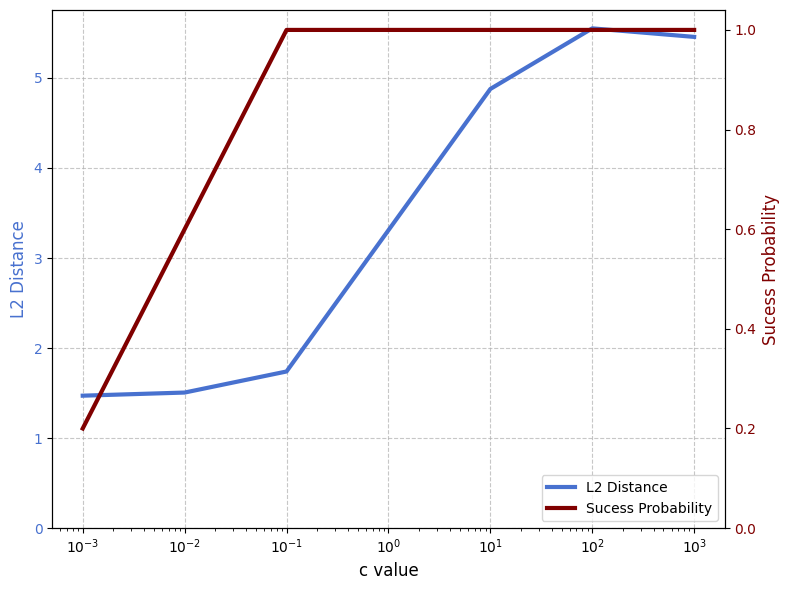

In [79]:
fig, ax1, ax2 = xlab.utils.plot_dual_2d(
    x=list(c_values_to_l2_sum.keys()), 
    y1=list(c_values_to_l2_sum.values()), 
    y2=list(c_values_to_prob.values()),
    y1_label='L2 Distance',
    y2_label='Sucess Probability',
    x_label='c value',
    y1_axis_label='L2 Distance',
    y2_axis_label='Sucess Probability',
    log_x=True,
)

### What do these results mean?

This shows that there is some tradeoff between $L_2$ distance and the probability of attack success. Perhaps an even better way to think about this is there is a tradeoff between how close an image is to it's original and how easily one can fool the model.

So if there is some kind of tradeoff present, how do we choose the best value for $c$? The author's make the following claim (note that $x^{*}$ is a notation for the adversarial example):

<blockquote>
    Empirically, we have found that often the best way to choose
$c$ is to use the smallest value of $c$ for which the resulting
solution $x^{*}$ has $f(x^{*}
)\leq 0$. This causes gradient descent to
minimize both of the terms simultaneously instead of picking
only one to optimize over first.
</blockquote>


In the paper the author's use a modified binary search to find this value of $c$. For brevity we leave this as an excercise to the reader but would not expect this to be too difficult to program. For our purposes, we observe that given a reasonable number of iterations in the $L_2$ setting, $c=0.015$ gives a high probability of success and undetectable perturbations in the $L_2$ setting.

## Task #6: Confidence-Adjusted $f$

For task 4 you found that $f_6$ was the most effective choice for $f$. For the $L_2$ attack that we will be implementing, the authors use a slight variation of $f_6$ which introduces a new constant $\tau$ which encourages the attack to find classifications that confidently choose the wrong class. This variation is shown below:

$$
f_6(x_{\mathrm{adversarial}}) = \max((\max_{i \neq t}(Z(x_{\mathrm{adversarial}}) - Z_t(x_{\mathrm{adversarial}})), -\tau)
$$

The $\tau$ parameter is different than the $c$ parameter because while the $c$ parameter weights how much the attack cares about the function $f$ the $\tau$ parameter determines a threshold for how confident of a misclassification $f$ is aiming for. 



In [28]:
def confident_f6(logits, target, tau):
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        masked_logits = logits.clone()
        masked_logits[target] = float('-inf')
        i_neq_t = torch.argmax(masked_logits)
    return torch.max((logits[i_neq_t] - logits[target]), -torch.tensor(tau))

In [81]:
tau = 0.01

x = torch.tensor([1.0, 3.0])
print(confident_f6(x, 0, tau)) # should be >0
x = torch.tensor([1.0, 1.0])
print(confident_f6(x, 0, tau)) # should be =0
x = torch.tensor([3.0, 1.0])
print(confident_f6(x, 0, tau)) # should be <0

tensor(2.)
tensor(0.)
tensor(-0.0100)


## Task 7-8: Change of variables

If you have not already read [our writeup for Carlini-Wagner attacks](https://xlabaisecurity.com/adversarial/cw/) on our website we highly recommend you do so now. Here is where things start to get tricky.

So far we have been thinking about adversarial examples as $x$ (the original image) plus a set of perturbations $\delta$ bounded by some $L_p$ norm. The issue is that $x + \delta$ can be greater than 1 or less than 0 which would make it an invalid image. Therefore, Carlini and Wagner propose writing $x + \delta$ as a function of a new variable $w$ where $f(w)$ is always between zero and one. Here is the equation they proposed:

$$
x_i + \delta_i = \frac{1}{2} (\tanh({w_i}) + 1)
$$

### Task #7: Caclculate $x + \delta$ given $w$

In task #6, you will calculate the above equation element-wise to find tensor $x + \delta$ given a tensor $w$.

In [16]:
def get_adv_from_w(w):
    return 0.5 * (torch.tanh(w) + 1)

### Task #8: Caclculate $x + \delta$ given $w$

In task #7, you will find the tensor for $\delta$--i.e., the difference between $x$ and the adversarial image.

In [17]:
def get_delta(w, x):
    return 0.5 * (torch.tanh(w) + 1) - x

Now, let's plot what we have found. If we randomly initialize $w$ we should see large values for delta which are both positive and negative. However, $x+\delta$ should be between 0 and 1. <b>You should not expect to see a reasonable adversarial image if you randomly initialize $w$.</b>

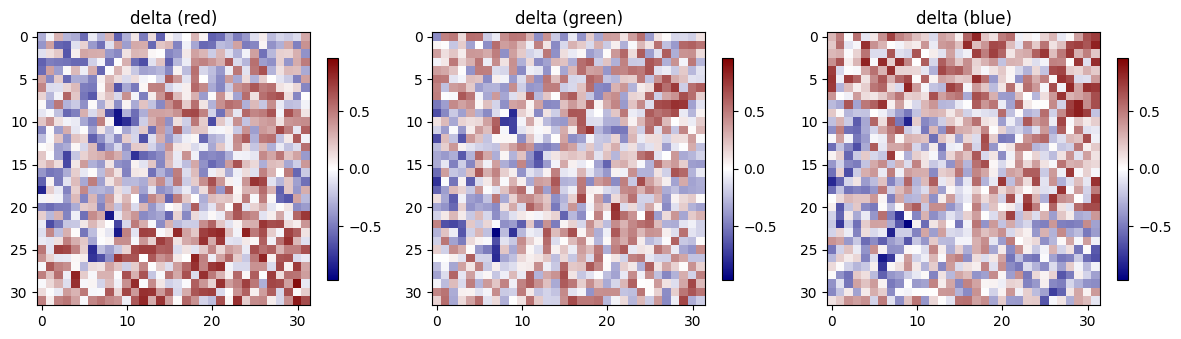

In [18]:
x_clean = x_test[0:0+1]
rand_w = torch.randn_like(x_clean)
adv = get_adv_from_w(rand_w)[0].cpu()
delta = get_delta(rand_w, x_clean)[0].cpu()

# you should expect to see positive and negative numbers
_ = xlab.utils.plot_tensors(
    [delta[0], delta[1], delta[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["delta (red)", "delta (green)", "delta (blue)"]
)

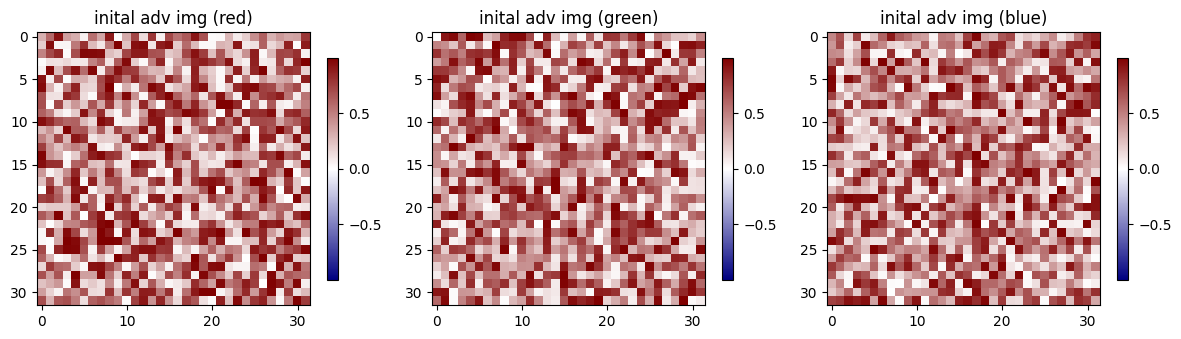

In [19]:
# you should expect to see plots of positive numbers between 0 and 1
_ = xlab.utils.plot_tensors(
    [adv[0], adv[1], adv[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["inital adv img (red)", "inital adv img (green)", "inital adv img (blue)"]
)

## Task #9: Putting it all together

Recall the following equation from [the webpage](https://xlabaisecurity.com/adversarial/cw/) associated with these exercises. This outlines the structure of the loss that the CW attack aims to minimize.

$$
\mathrm{minimize} \ \   \| \delta \|_p + c \cdot f(x + \delta)
$$

With the change of variable shown above, this becomes:

$$
\mathrm{minimize} \ \   \| \frac{1}{2} (\tanh({w}) + 1) - x \|_p + c \cdot f(\frac{1}{2} (\tanh({w}) + 1))
$$

Now we will use this equation to implement that $L_2$ Carlini-Wagner attack the way that the authors constructed it in the original paper. There are two details that require your attention before continuing: 

1. The authors use $\| \delta \|_2^2$ rather than $\| \delta \|_2$ to minimize the size of $\delta$.
2. The authors choose $f$ to be the function you implemented in `confident_f6` rather than the function you implemented in `f6`

This means your loss should look like this:

$$
\mathrm{minimize} \ \   \| \frac{1}{2} (\tanh({w}) + 1) - x \|_2^2 + c \cdot f_{\mathrm{6-confident}}(\frac{1}{2} (\tanh({w}) + 1))
$$




In [29]:
def CW_targeted_l2(img, model, c, target, k=0.1, l2_limit=0.5, num_iters=100):
    device = next(model.parameters()).device
    print(f"Using device: {device} for testing...")

    cw_weights = torch.randn_like(img).to(device) * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    delta = get_delta(cw_weights, img)

    for _ in range(num_iters):
        logits = model(img + delta)

        # stop attack early if the model predicts target class and delta is in our budget
        if (
            torch.argmax(logits[0]) == target
            and torch.sum((delta) ** 2).item() <= l2_limit
        ):
            return img + delta

        assert confident_f6(logits[0], target, k) >= -k
            
        success_loss = c * confident_f6(logits[0], target, k)
        l2_reg = torch.sum((delta) ** 2)

        loss = success_loss + l2_reg
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        delta = get_delta(cw_weights, img)

    print("warning! targeted attack was not successful")
    return img + delta

In [38]:
a = CW_targeted_l2(x_test[0:1], model, 0.015, 2, k=0.1, l2_limit=0.5, num_iters=100)

Using device: cuda:0 for testing...


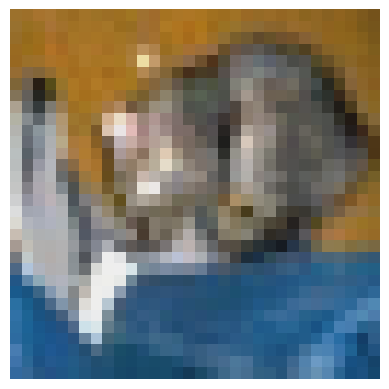

In [39]:
show_image(a.cpu())

In [40]:
model(a)

tensor([[-4.2103, -0.4826, 12.0126,  2.1273, -4.0483,  2.0396, -2.6761, -0.7172,
          0.7923, -4.8351]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [31]:
delta.shape

torch.Size([1, 3, 32, 32])

In [94]:
x_clean = x_test[0:1].to(device)

adv_image = cw_simple(f6, x_clean, 1, 100, model, 50)

iteration 5:	 loss=16.3431
iteration 10:	 loss=17.3085
iteration 15:	 loss=17.8474
iteration 20:	 loss=18.0310
iteration 25:	 loss=17.9607
iteration 30:	 loss=17.7223
iteration 35:	 loss=17.3782
iteration 40:	 loss=16.9716
iteration 45:	 loss=16.5308
iteration 50:	 loss=16.0749


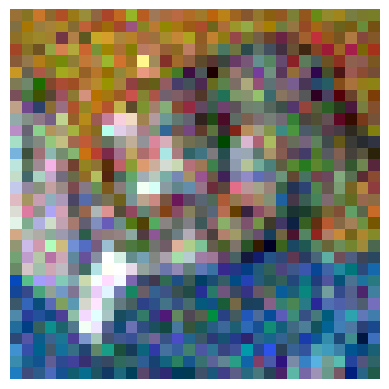

In [95]:
show_image(adv_image.cpu())

In [96]:
distance(adv_image, x_clean, 2).item()

5.565356731414795

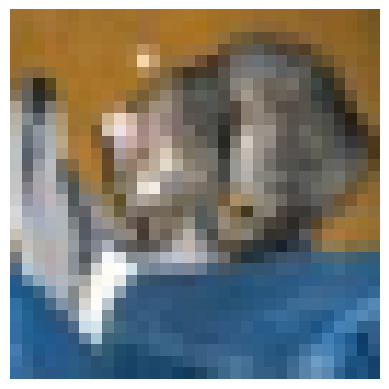

In [73]:
show_image(x_clean.cpu())

In [34]:
def show_image(img):
    """
    Display image tensor using plt
    
    Parameters:
    -----------
    img : Tensor
        image Tensor to be displayed
    """
    img = img.squeeze(0)
    plt.imshow(img.permute(1, 2, 0).detach().numpy())
    plt.axis('off')  # Remove both axes entirely

In [25]:
adv = adv[0].detach().cpu()
x = x_test[0].detach().cpu()
delta = adv - x

_ = xlab.utils.plot_tensors(
    [delta[0], delta[1], delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

NameError: name 'adv' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050887734..1.0007143].


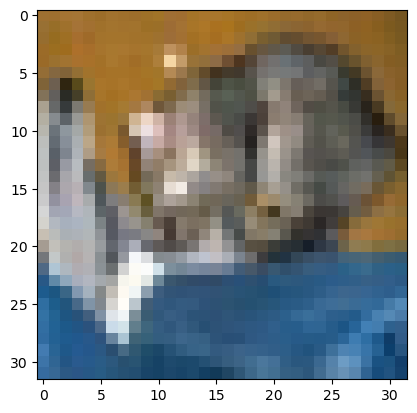

In [283]:
plt.imshow(adv[0].detach().cpu().permute(1,2,0))

In [ ]:
F.cross_entropy(torch.tensor([1.0, 2, 3]), torch.tensor(1))

In [135]:
torch.log(F.softmax(torch.tensor([1.0, 2, 3]), dim=0))

tensor([-2.4076, -1.4076, -0.4076])

$$
f_1(x_{\mathrm{adversarial}}) = -C(F(x_{\mathrm{adversarial}})) + 1
$$

In [2]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


In [4]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


In [152]:
def f_6(logits, target, k=0):
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    print("in f6", (logits[i_neq_t] - logits[target]).item())
    return torch.max(logits[i_neq_t] - logits[target], -torch.tensor(k))
            

def CW_targeted_l2(img, model, c, target, k=1):
    
    cw_weights = torch.randn_like(img).to('mps') * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    num_iters = 100
    delta = 0.5 * (F.tanh(cw_weights) + 1) - img

    k = 0.1

    for i in range(num_iters):
        
        logits = model((img + delta).unsqueeze(0))

        if torch.argmax(logits[0]) == target and torch.sum((delta)**2) <= 0.5:
            return delta

        # print(f_6(logits[0], target))
        assert f_6(logits[0], target, k) >= -k
        success_loss = c * f_6(logits[0], target, k)
        l2_reg = torch.sum((delta)**2)

        loss = success_loss + l2_reg
        print(loss, success_loss, l2_reg)
        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        delta = 0.5 * (F.tanh(cw_weights) + 1) - img
    print("warning! targeted attack was not successful")
    return delta

In [153]:
torch.max(torch.tensor(5), torch.tensor(-2))

tensor(5)

In [154]:
x = x_test[0]

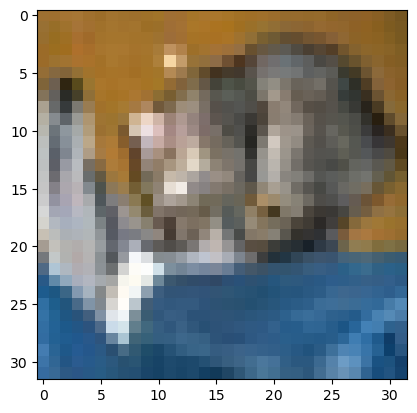

In [155]:
plt.imshow(x.permute(1,2,0).cpu())

In [156]:
out_delta = CW_targeted_l2(x.to('mps'), model, 0.01, 1)

in f6 7.889273643493652
in f6 7.889273643493652
tensor(120.1354, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0789, device='mps:0', grad_fn=<MulBackward0>) tensor(120.0565, device='mps:0', grad_fn=<SumBackward0>)
in f6 8.08248233795166
in f6 8.08248233795166
tensor(97.0092, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0808, device='mps:0', grad_fn=<MulBackward0>) tensor(96.9284, device='mps:0', grad_fn=<SumBackward0>)
in f6 14.96743392944336
in f6 14.96743392944336
tensor(77.6946, device='mps:0', grad_fn=<AddBackward0>) tensor(0.1497, device='mps:0', grad_fn=<MulBackward0>) tensor(77.5449, device='mps:0', grad_fn=<SumBackward0>)
in f6 4.813962936401367
in f6 4.813962936401367
tensor(61.6276, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0481, device='mps:0', grad_fn=<MulBackward0>) tensor(61.5795, device='mps:0', grad_fn=<SumBackward0>)
in f6 1.4890851974487305
in f6 1.4890851974487305
tensor(48.6323, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0149, device='mps:0', gra

In [157]:
out_delta.shape

torch.Size([3, 32, 32])

In [158]:
8/255

0.03137254901960784

In [159]:
out_delta.min(), out_delta.max()

(tensor(-0.0629, device='mps:0', grad_fn=<MinBackward1>),
 tensor(0.0464, device='mps:0', grad_fn=<MaxBackward1>))

In [160]:
max_diff = torch.max(torch.abs(out_delta))

In [161]:
max_diff

tensor(0.0629, device='mps:0', grad_fn=<MaxBackward1>)

In [119]:
assert max_diff < 8/255

Now let's plot what we have. You should 

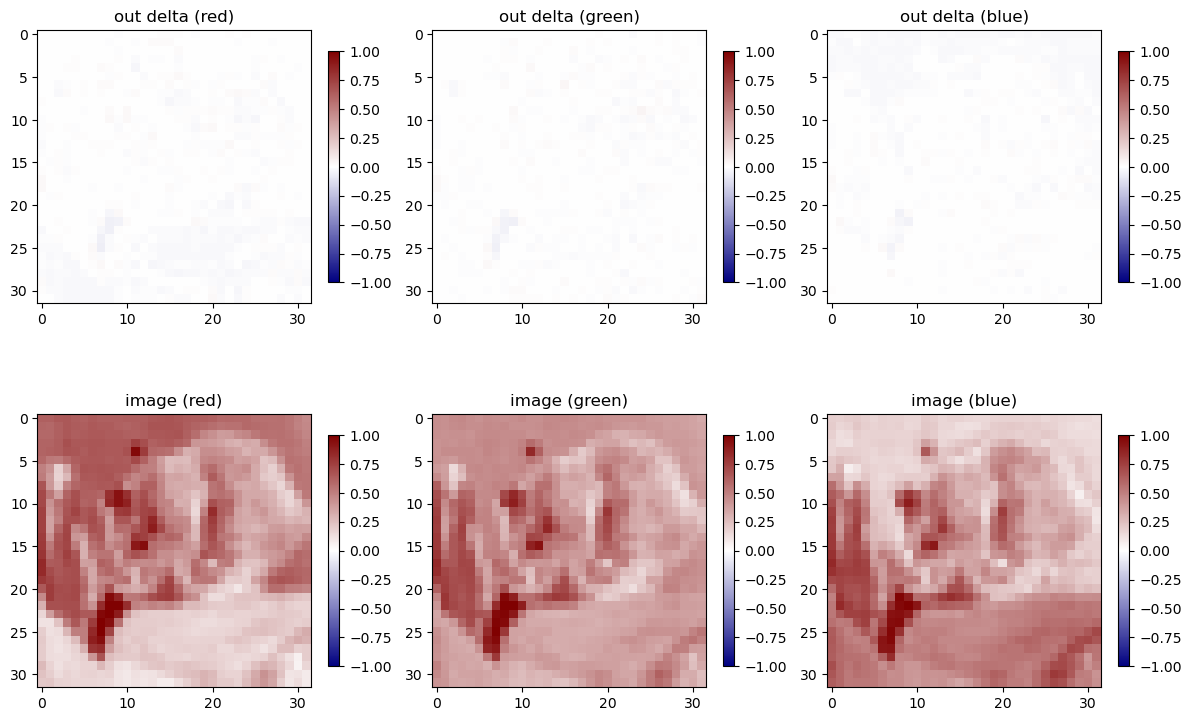

In [162]:
out_delta = out_delta.detach().cpu()

_ = xlab.utils.plot_tensors(
    [out_delta[0], out_delta[1], out_delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

In [43]:
x_adv = out_delta + x

In [44]:
model(x_adv.unsqueeze(0))

tensor([[13.4251, -0.7176, -1.3678,  3.0889, -5.2713, -1.6484, -1.6464, -2.5078,
         -1.8055, -1.4932]], device='mps:0', grad_fn=<LinearBackward0>)

In [45]:
x_adv.shape

torch.Size([3, 32, 32])

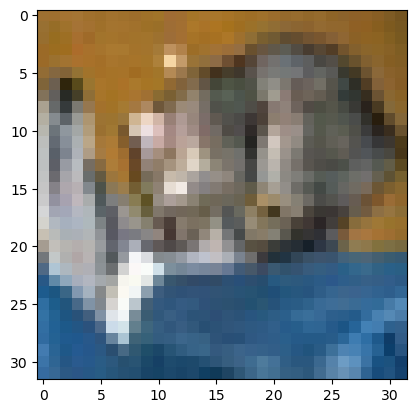

In [46]:
plt.imshow(x_adv.detach().permute(1,2,0).cpu())

## Choosing a constant $c$


<blockquote>
    Empirically, we have found that often the best way to choose
$c$ is to use the smallest value of $c$ for which the resulting
solution $x^{*}$ has $f(x^{*}
)\leq 0$. This causes gradient descent to
minimize both of the terms simultaneously instead of picking
only one to optimize over first.
</blockquote>



On choosing a good $f$:

<blockquote>
The choice of method
for handling box constraints does not impact the quality of
results as significantly for the best minimization functions.
</blockquote>